## Introduction

In this notebook, we solve the Navier-Stokes equations for a 2D incompressible flow using a finite difference method. We will implement a baseline solution, optimize it using Numba for CPU parallelization, and further accelerate computations using GPU kernels.


In [1]:
import numpy as np
from numba import njit, prange, cuda
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

With such conditions we have laminar flow

In [2]:
nx, ny = 1024, 1024
dx, dy = 1.0 / nx, 1.0 / ny
dt = 0.0000001
nt = 100

rho = 1.0
p = np.zeros((nx, ny), dtype=np.float64)


With such there is turbulance

In [3]:
nu = 0.0001  # Very low viscosity to induce turbulence

# Modify initial conditions with random perturbations
u = np.zeros((nx, ny), dtype=np.float64)
v = np.zeros((nx, ny), dtype=np.float64)

# Add random initial disturbances
np.random.seed(42)  # For reproducibility
u += 0.1 * np.random.randn(nx, ny)
v += 0.1 * np.random.randn(nx, ny)

# Add a large vortex in the center for stronger turbulence
cx, cy = nx // 2, ny // 2
u[cx-10:cx+10, cy-10:cy+10] = 2.0
v[cx-10:cx+10, cy-10:cy+10] = -2.0

# Boundary conditions remain zero
u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0

## Baseline CPU Solver

Below is the naive Python implementation of the Navier-Stokes step. It uses pure NumPy operations in loops. This version is straightforward but not efficient for large grids. We use it as a reference for further optimization.



In [4]:
# (PYTHON CELL) - Baseline CPU implementation
def navier_stokes_cpu(u, v, p, nu, rho, dx, dy, dt, nt):
    u = u.copy()
    v = v.copy()
    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        u[1:-1, 1:-1] = (un[1:-1, 1:-1] 
                         - un[1:-1, 1:-1]*dt/dx*(un[1:-1, 1:-1]-un[:-2, 1:-1]) 
                         - vn[1:-1, 1:-1]*dt/dy*(un[1:-1, 1:-1]-un[1:-1, :-2])
                         + nu*dt*((un[2:, 1:-1]-2*un[1:-1, 1:-1]+un[:-2, 1:-1])/dx**2 
                                  + (un[1:-1, 2:]-2*un[1:-1, 1:-1]+un[1:-1, :-2])/dy**2) + 1e-8)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] 
                         - un[1:-1, 1:-1]*dt/dx*(vn[1:-1, 1:-1]-vn[:-2, 1:-1]) 
                         - vn[1:-1, 1:-1]*dt/dy*(vn[1:-1, 1:-1]-vn[1:-1, :-2])
                         + nu*dt*((vn[2:, 1:-1]-2*vn[1:-1, 1:-1]+vn[:-2, 1:-1])/dx**2 
                                  + (vn[1:-1, 2:]-2*vn[1:-1, 1:-1]+vn[1:-1, :-2])/dy**2) + 1e-8)

        # Apply boundary conditions
        u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
        v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0

    return u, v

# Timing the baseline
start = time.time()
u_cpu, v_cpu = navier_stokes_cpu(u, v, p, nu, rho, dx, dy, dt, nt)
cpu_time = time.time() - start
print("CPU Time:", cpu_time, "s")


CPU Time: 5.0111799240112305 s



## Numba-Accelerated CPU Solver

Next, we use Numba’s `njit` and `prange` to parallelize the loops over the grid. This typically yields a substantial speed-up on multicore CPUs.



In [5]:
@njit(parallel=True, fastmath=True)
def navier_stokes_numba(u, v, p, nu, rho, dx, dy, dt, nt):
    u = u.copy()
    v = v.copy()
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        for i in prange(1, u.shape[0]-1):
            for j in range(1, u.shape[1]-1):
                u[i,j] = (un[i,j] 
                          - un[i,j]*dt/dx*(un[i,j]-un[i-1,j]) 
                          - vn[i,j]*dt/dy*(un[i,j]-un[i,j-1]) 
                          + nu*dt*((un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2 
                                   + (un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2) + 1e-8)

                v[i,j] = (vn[i,j] 
                          - un[i,j]*dt/dx*(vn[i,j]-vn[i-1,j]) 
                          - vn[i,j]*dt/dy*(vn[i,j]-vn[i,j-1]) 
                          + nu*dt*((vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2 
                                   + (vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2) + 1e-8)

        # Boundary conditions
        for j in range(u.shape[1]):
            u[0, j], u[-1, j] = 0, 0
            v[0, j], v[-1, j] = 0, 0
        for i in range(u.shape[0]):
            u[i, 0], u[i, -1] = 0, 0
            v[i, 0], v[i, -1] = 0, 0

    return u, v

# Timing the Numba version
start = time.time()
u_numba, v_numba = navier_stokes_numba(u, v, p, nu, rho, dx, dy, dt, nt)
numba_time = time.time() - start
print("Numba Time:", numba_time, "s")

Numba Time: 1.7142753601074219 s



## GPU-Accelerated Solver using Numba CUDA

Here, we offload computations to the GPU. We define CUDA kernels that update `u` and `v` in parallel on the device. We need to manage device arrays, copy data to the GPU, run the kernel, and then copy results back. This approach can significantly reduce compute times, especially for large grids.


In [6]:
@cuda.jit
def navier_stokes_step_kernel(u, v, un, vn, nu, rho, dx, dy, dt, nx, ny):
    i, j = cuda.grid(2)
    if 1 <= i < nx-1 and 1 <= j < ny-1:
        # Update u velocity
        u[i, j] = (un[i, j] 
                  - un[i, j] * dt / dx * (un[i, j] - un[i - 1, j]) 
                  - vn[i, j] * dt / dy * (un[i, j] - un[i, j - 1]) 
                  + nu * dt * ((un[i + 1, j] - 2 * un[i, j] + un[i - 1, j]) / dx**2 
                               + (un[i, j + 1] - 2 * un[i, j] + un[i, j - 1]) / dy**2) + 1e-8)

        # Update v velocity
        v[i, j] = (vn[i, j] 
                  - un[i, j] * dt / dx * (vn[i, j] - vn[i - 1, j]) 
                  - vn[i, j] * dt / dy * (vn[i, j] - vn[i, j - 1]) 
                  + nu * dt * ((vn[i + 1, j] - 2 * vn[i, j] + vn[i - 1, j]) / dx**2 
                               + (vn[i, j + 1] - 2 * vn[i, j] + vn[i, j - 1]) / dy**2) + 1e-8)

def navier_stokes_gpu(u, v, p, nu, rho, dx, dy, dt, nt):
    # Copy data to the GPU
    u_d = cuda.to_device(u)
    v_d = cuda.to_device(v)
    un_d = cuda.device_array_like(u_d)
    vn_d = cuda.device_array_like(v_d)

    # Grid and block configuration
    blockdim = (16, 16)
    griddim = ((u.shape[0] + blockdim[0] - 1) // blockdim[0],
               (u.shape[1] + blockdim[1] - 1) // blockdim[1])

    for n in range(nt):
        # Copy u and v to temporary arrays
        un_d.copy_to_device(u_d.copy_to_host())
        vn_d.copy_to_device(v_d.copy_to_host())

        # Launch GPU kernel
        navier_stokes_step_kernel[griddim, blockdim](u_d, v_d, un_d, vn_d, nu, rho, dx, dy, dt, u.shape[0], u.shape[1])
        cuda.synchronize()

    # Copy results back to the host
    u = u_d.copy_to_host()
    v = v_d.copy_to_host()
    return u, v

# Timing the GPU version
start = time.time()
u_gpu, v_gpu = navier_stokes_gpu(u, v, p, nu, rho, dx, dy, dt, nt)
gpu_time = time.time() - start
print("GPU Time:", gpu_time, "s")


GPU Time: 0.7448163032531738 s


## Stability Check

We implement a simple CFL-based stability check to ensure the chosen timestep is stable.



In [7]:
def check_stability(dx, dy, dt, nu):
    max_speed = np.sqrt(2 * nu / (dx**2 + dy**2))
    cfl_condition = max_speed * dt / min(dx, dy)
    return cfl_condition < 0.5

is_stable = check_stability(dx, dy, dt, nu)
print("Stability check passed:", is_stable)


Stability check passed: True


## Performance Comparison

We compare the execution times of the three methods:  
- Baseline CPU  
- Numba-Accelerated CPU  
- GPU-Accelerated

We will plot a bar chart for a quick visual comparison.

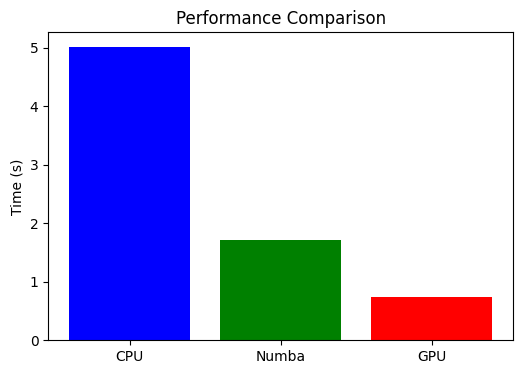

In [8]:
methods = ["CPU", "Numba", "GPU"]
times = [cpu_time, numba_time, gpu_time]

plt.figure(figsize=(6,4))
plt.bar(methods, times, color=['blue', 'green', 'red'])
plt.ylabel("Time (s)")
plt.title("Performance Comparison")
plt.show()


## Visualization of the Flow Field

We can visualize the flow field using streamlines or a quiver plot to see how the turbulence evolves. Here, we show a final velocity field visualization. For a more dynamic impression, we can also create an animation.


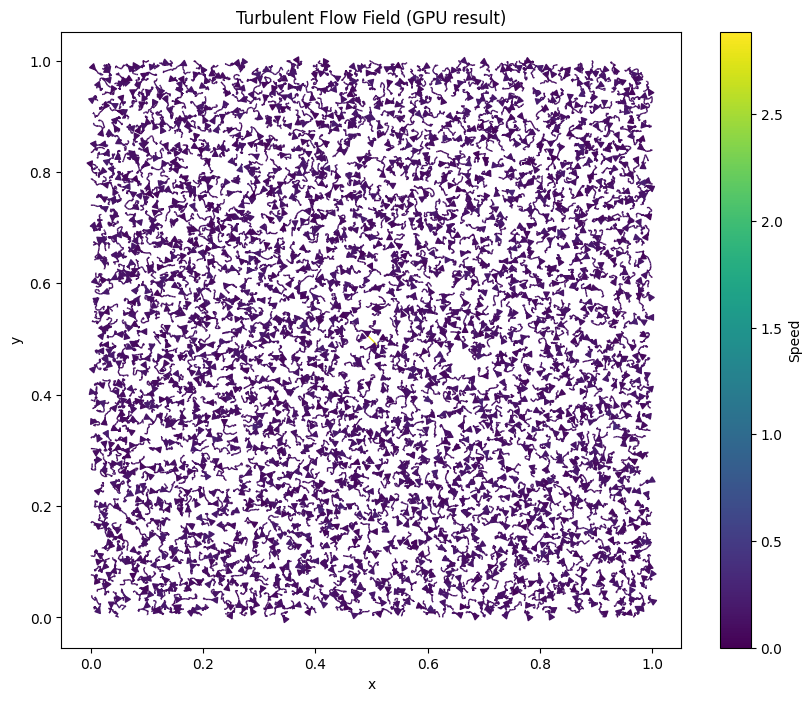

In [9]:
X, Y = np.meshgrid(np.linspace(0,1,ny), np.linspace(0,1,nx))
plt.figure(figsize=(10,8))
plt.streamplot(X, Y, u_gpu, v_gpu, density=4, linewidth=1, color=np.sqrt(u_gpu**2 + v_gpu**2))
plt.title("Turbulent Flow Field (GPU result)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Speed")
plt.show()

# Animation

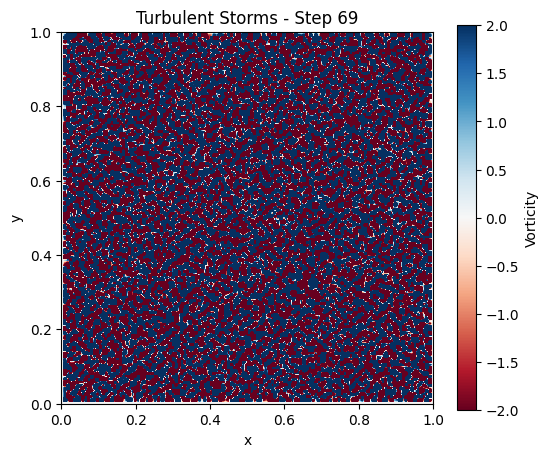

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import njit, prange

# Simulation parameters
nx, ny = 128, 128       # Grid size
dx, dy = 1.0 / nx, 1.0 / ny
dt = 0.0001             # Time step
nu = 0.00001               # Viscosity
nt = 70                # Number of time steps for the animation

# Initialize velocity fields (u, v) with perturbations for turbulence
u = np.zeros((nx, ny), dtype=np.float64)
v = np.zeros((nx, ny), dtype=np.float64)
np.random.seed(42)
u += 0.2 * np.random.randn(nx, ny)  # Initial random perturbation
v += 0.2 * np.random.randn(nx, ny)

# Apply boundary conditions
u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0

# Optimized single step update function
@njit(parallel=True, fastmath=True)
def single_step_update(u, v, dx, dy, dt, nu):
    un = u.copy()
    vn = v.copy()

    for i in prange(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            u[i, j] = (un[i, j]
                       - un[i, j] * dt / dx * (un[i, j] - un[i - 1, j])
                       - vn[i, j] * dt / dy * (un[i, j] - un[i, j - 1])
                       + nu * dt * ((un[i + 1, j] - 2 * un[i, j] + un[i - 1, j]) / dx**2
                                    + (un[i, j + 1] - 2 * un[i, j] + un[i, j - 1]) / dy**2))

            v[i, j] = (vn[i, j]
                       - un[i, j] * dt / dx * (vn[i, j] - vn[i - 1, j])
                       - vn[i, j] * dt / dy * (vn[i, j] - vn[i, j - 1])
                       + nu * dt * ((vn[i + 1, j] - 2 * vn[i, j] + vn[i - 1, j]) / dx**2
                                    + (vn[i, j + 1] - 2 * vn[i, j] + vn[i, j - 1]) / dy**2))

    # Apply boundary conditions
    u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
    v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0
    return u, v

# Optimized vorticity computation
@njit(parallel=True, fastmath=True)
def compute_vorticity(u, v, dx, dy):
    omega = np.zeros_like(u)
    for i in prange(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            dvdx = (v[i + 1, j] - v[i - 1, j]) / (2 * dx)
            dudy = (u[i, j + 1] - u[i, j - 1]) / (2 * dy)
            omega[i, j] = dvdx - dudy
    return omega

# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(6, 5))
X, Y = np.meshgrid(np.linspace(0, 1, ny), np.linspace(0, 1, nx))

# Initial vorticity computation
omega = compute_vorticity(u, v, dx, dy)
contour = ax.imshow(omega, cmap='RdBu', origin='lower', extent=[0, 1, 0, 1],
                    vmin=-2, vmax=2)
ax.set_title("Turbulent Storms - Step 0")
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = fig.colorbar(contour, label='Vorticity')

# Update function for animation
def update(frame):
    global u, v
    # Update the velocity fields
    u, v = single_step_update(u, v, dx, dy, dt, nu)
    # Compute vorticity
    omega = compute_vorticity(u, v, dx, dy)
    contour.set_data(omega)
    ax.set_title(f"Turbulent Storms - Step {frame}")
    return [contour]

# Animate and save as GIF
anim = FuncAnimation(fig, update, frames=nt, interval=5, blit=False)
writer = PillowWriter(fps=120)
anim.save("turbulent_flow.gif", writer=writer)

plt.show()
